In [14]:
# IMPORTS
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cut_tree
import matplotlib.pyplot as plt
import networkx as ntwkx
import os

In [15]:
## Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('notebooks')

## Load the dataset
geneExpression = working_dir + 'data/5xFAD_paper/expressionList.csv'
dataset = pd.read_csv(geneExpression, index_col=0) 

## Make a subset to save RAM
subset_dataset_size = 1000
dataset = dataset.iloc[:, :subset_dataset_size] 
#susbsetFile = '5xFAD_paper/expressionListSubset.csv' 
#dataset.to_csv(susbsetFile, sep=',', index=False, encoding='utf-8') 

In [16]:
## RAM usage estimation in GB
RAM_estimate = (subset_dataset_size * subset_dataset_size * 8) / (1024**3)
print(f"The aproximated RAM to analyse this size of dataset is: {RAM_estimate} GB")

The aproximated RAM to analyse this size of dataset is: 0.007450580596923828 GB


Columns with zero variance being removed: ['ENSMUSG00000000003', 'ENSMUSG00000000103', 'ENSMUSG00000001804', 'ENSMUSG00000003053', 'ENSMUSG00000004344']


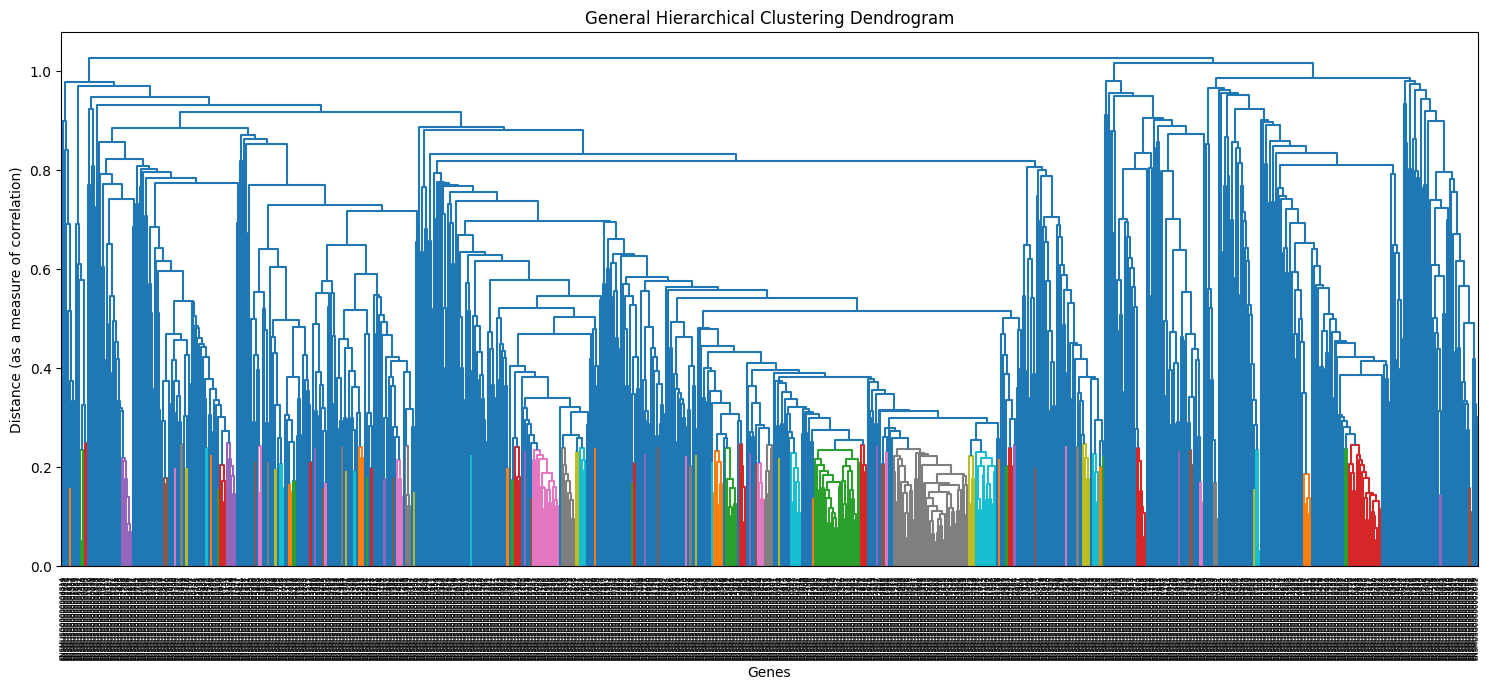

In [17]:
### BASIC DENDOGRAM USING CORRELATOIN AS THE DISTANCE 
dpi_general = 500
module_member_threshold = 0.25   ## Set the threshold value to consider members of a module.




## We check for zero variance genes & Nan
variances = dataset.var()  # Compute variance for each column
zero_var_columns = variances[variances == 0].index 
dataset_filtered = dataset.drop(columns=zero_var_columns)
print("Columns with zero variance being removed:", zero_var_columns.tolist())


## Compute the metrics for the dendogram based on clustering genes (now rows)
distances = pdist(dataset_filtered.T, metric='correlation')
linkage_matrix =  linkage(distances, method="average")


## Plot the dendrogram
plt.figure(figsize=(15, 7))  # Adjust the size as needed
dendrogram(linkage_matrix, truncate_mode=None, color_threshold=module_member_threshold, 
           labels=dataset_filtered.T.index, leaf_rotation=90)
title_general_dendogram = 'General Hierarchical Clustering Dendrogram'
plt.title(title_general_dendogram)
plt.xlabel('Genes')
plt.ylabel('Distance (as a measure of correlation)')
plt.tight_layout()
plt.savefig(working_dir + 'results\\Hierarchical_Clustering_figures\\' + title_general_dendogram, dpi=dpi_general)
plt.show()


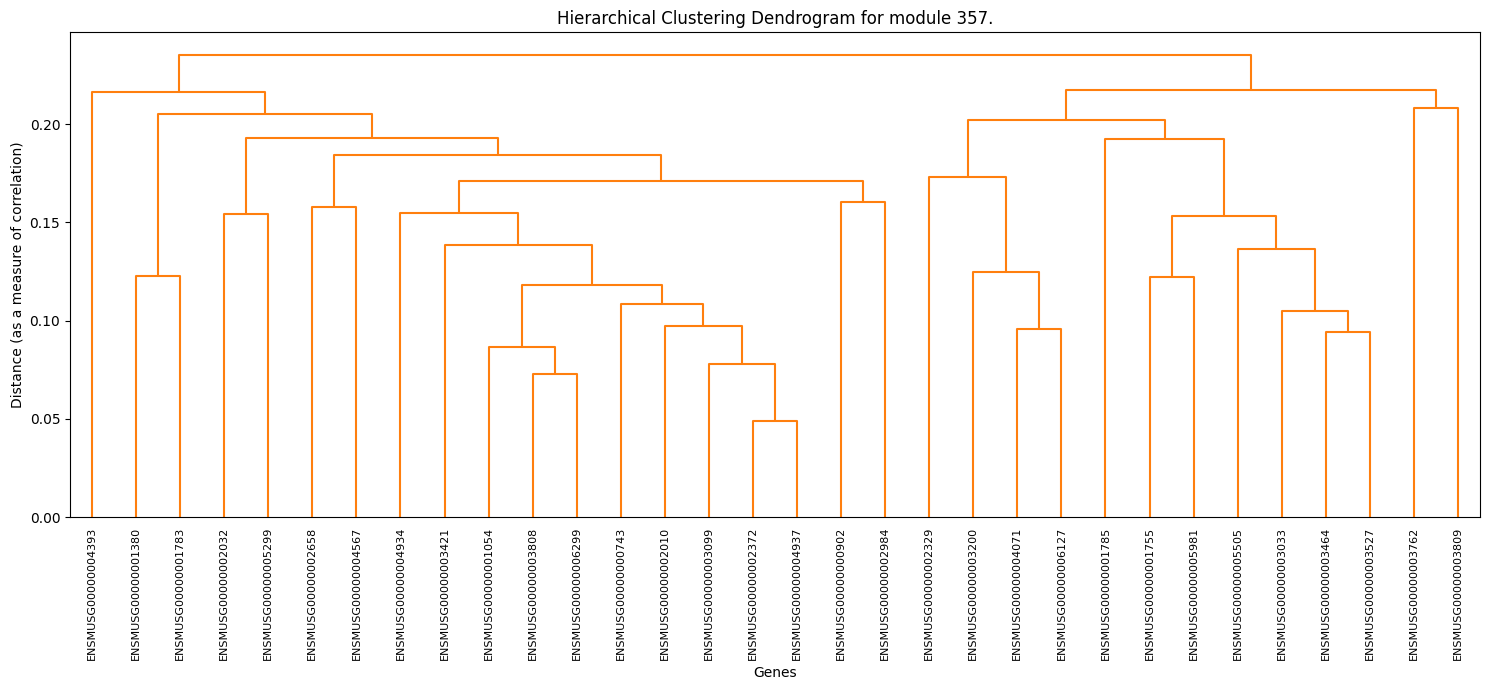

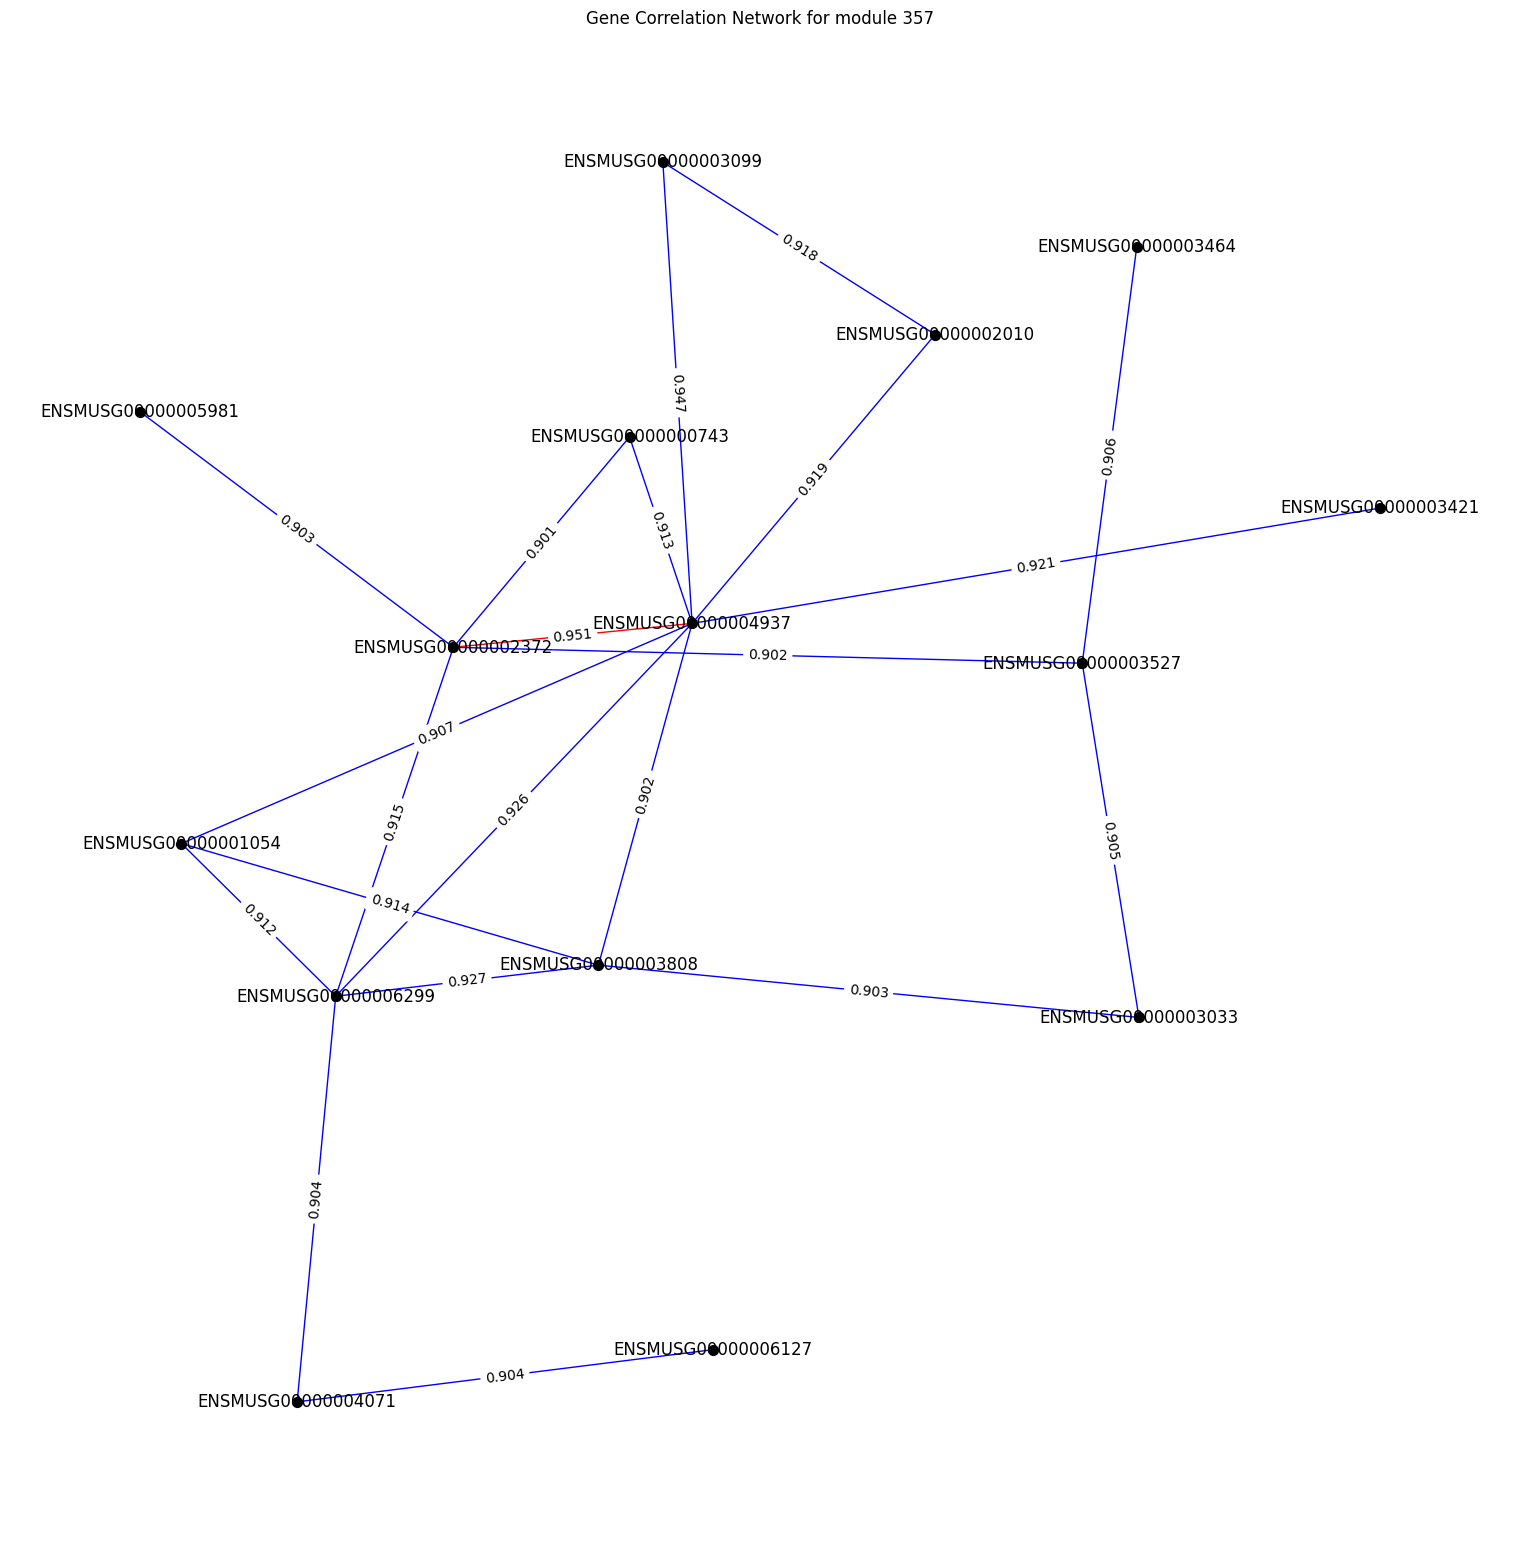

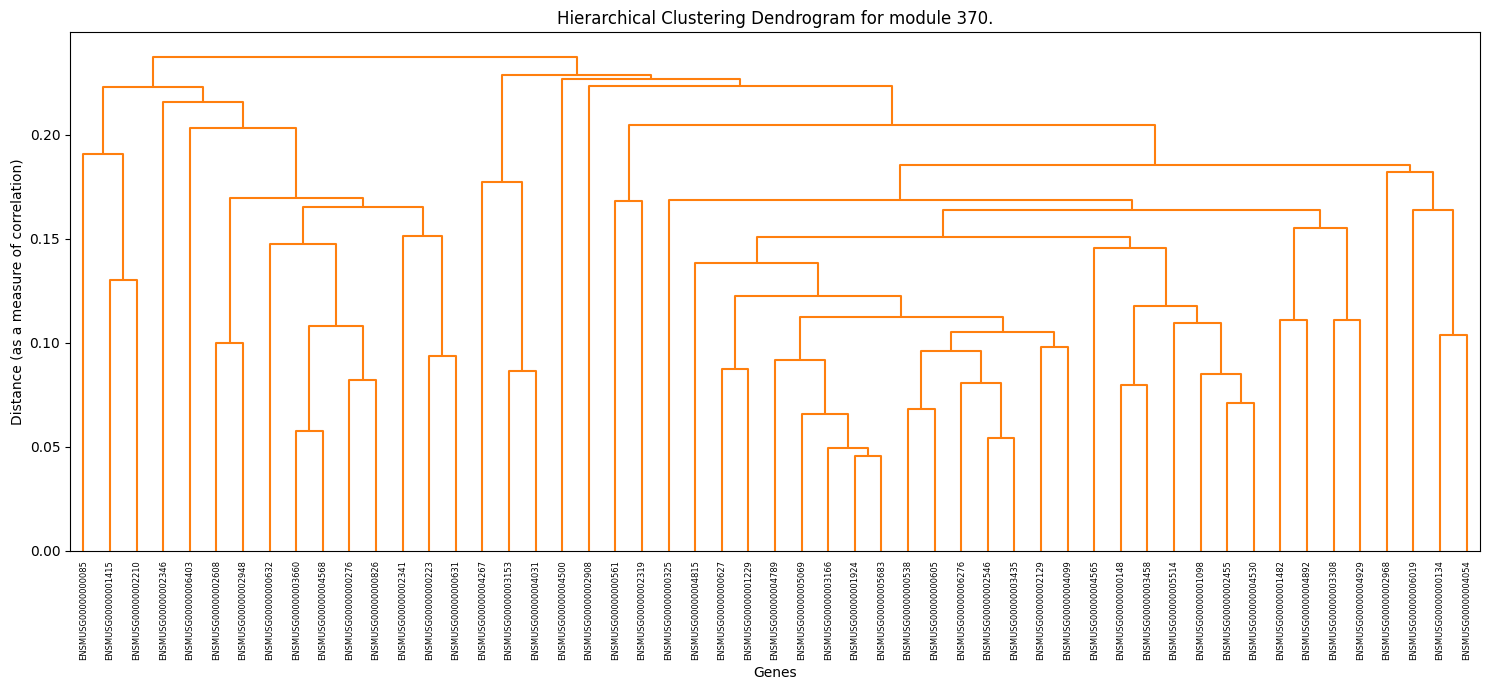

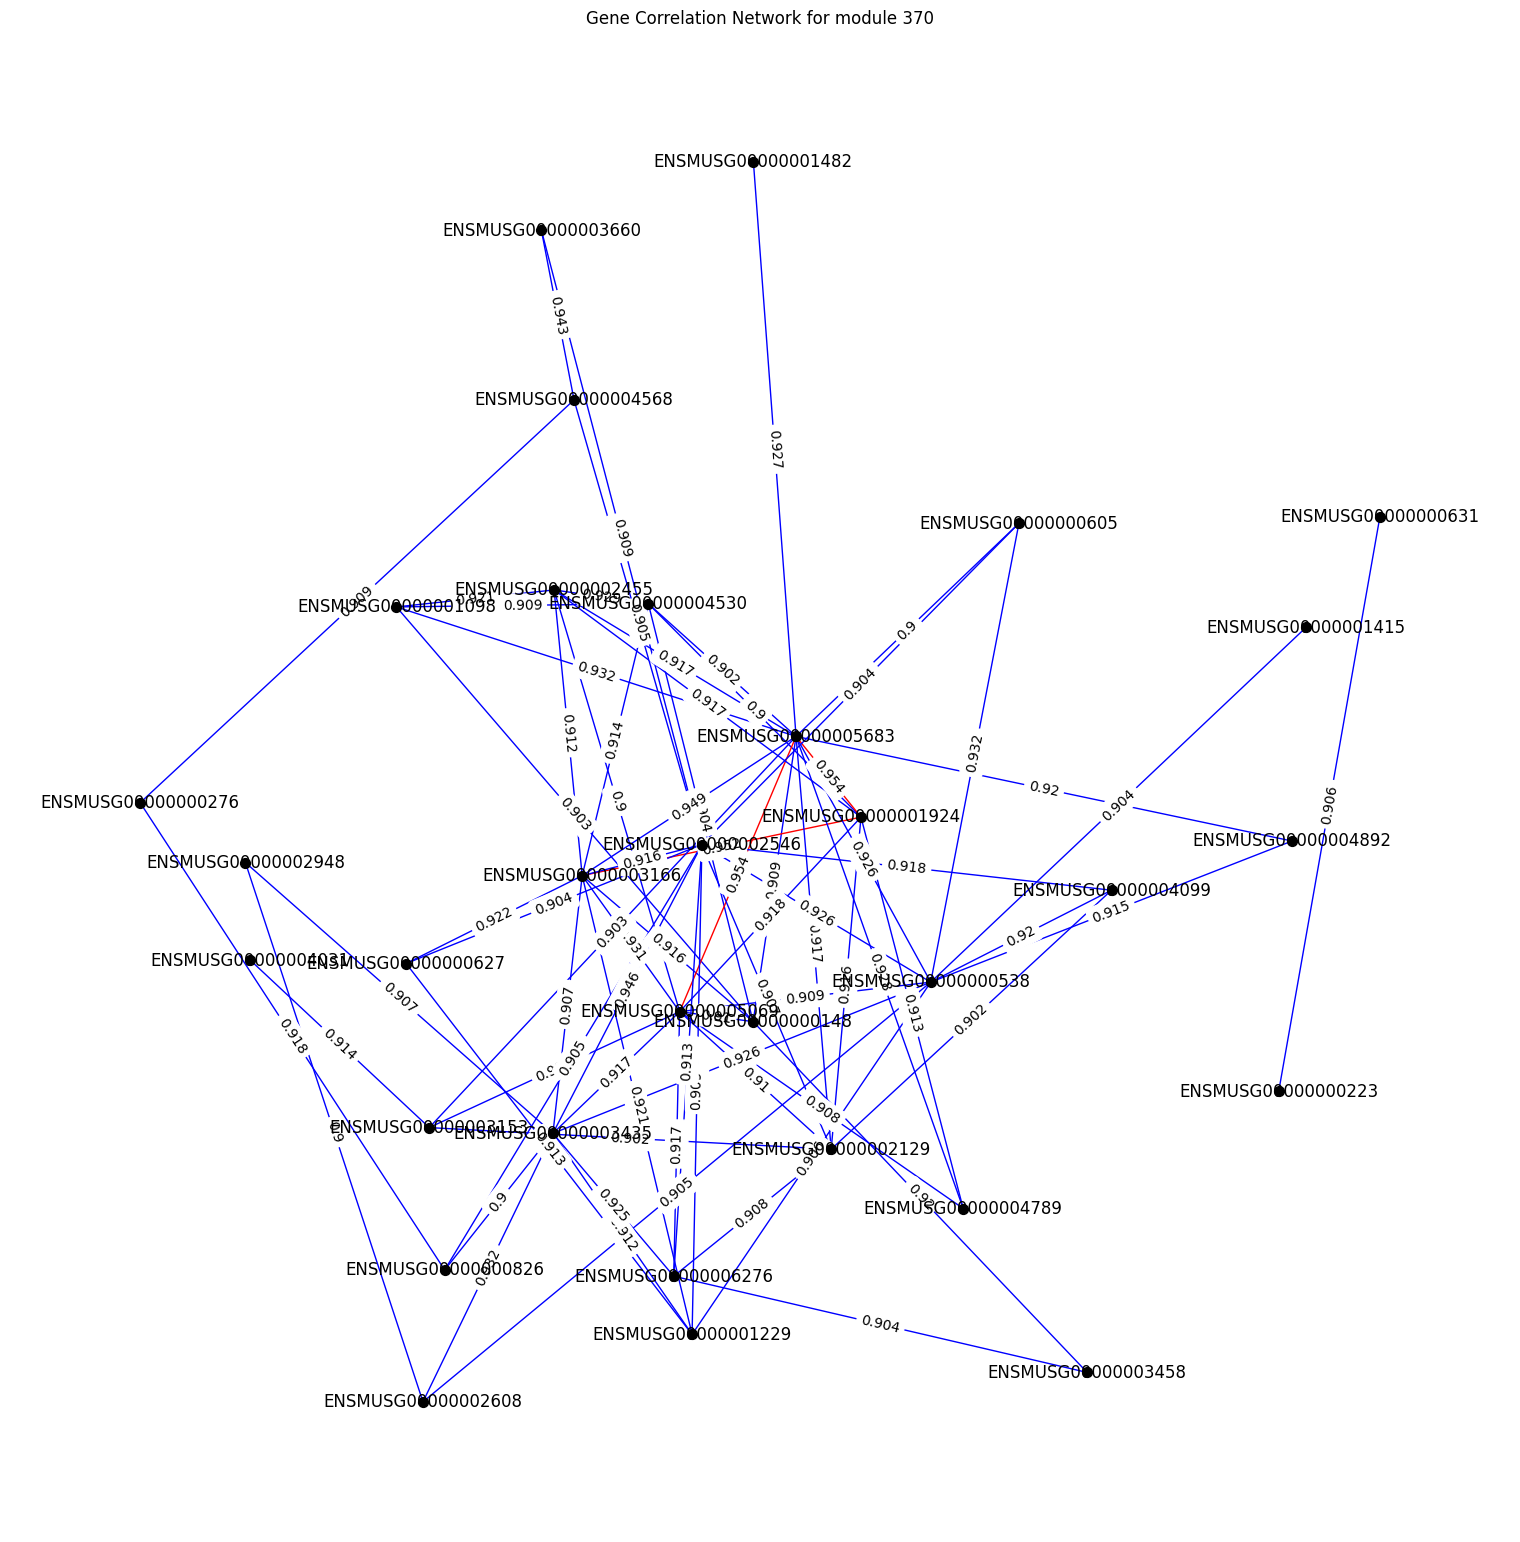

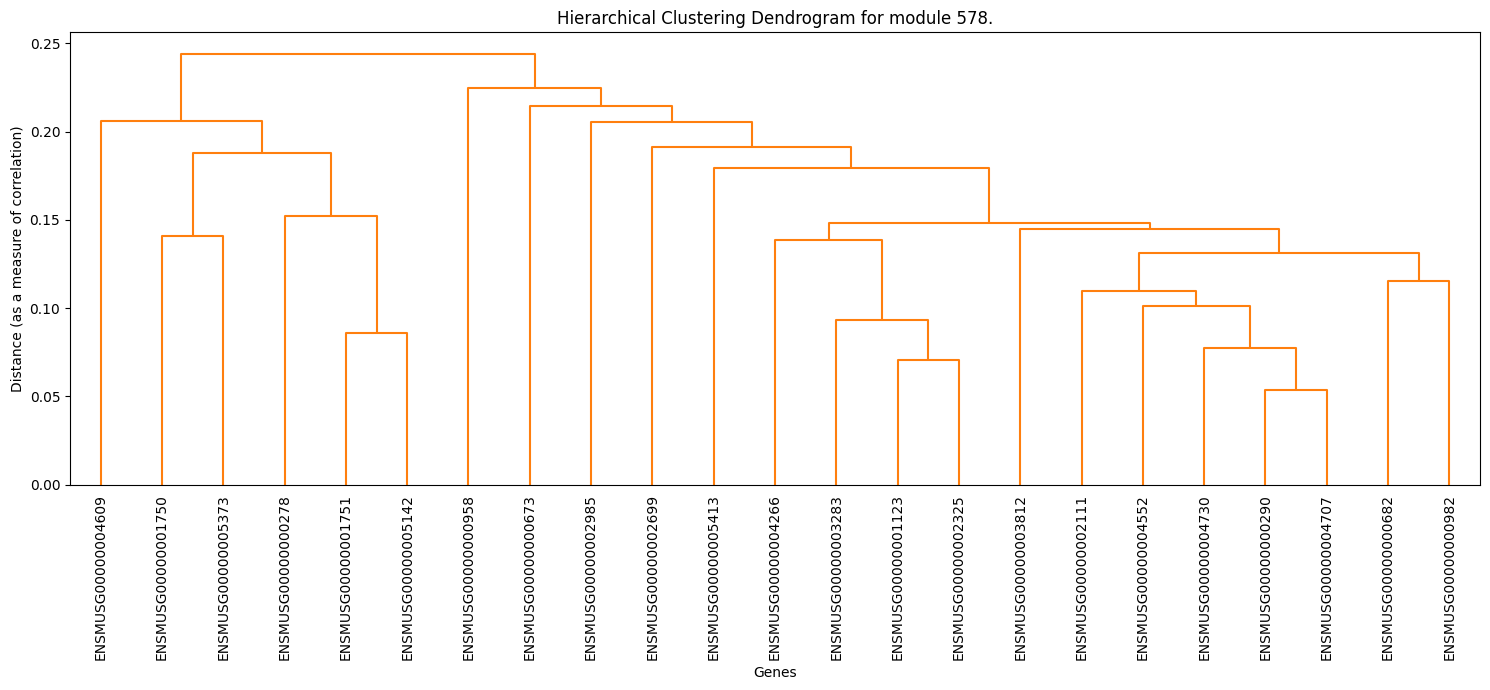

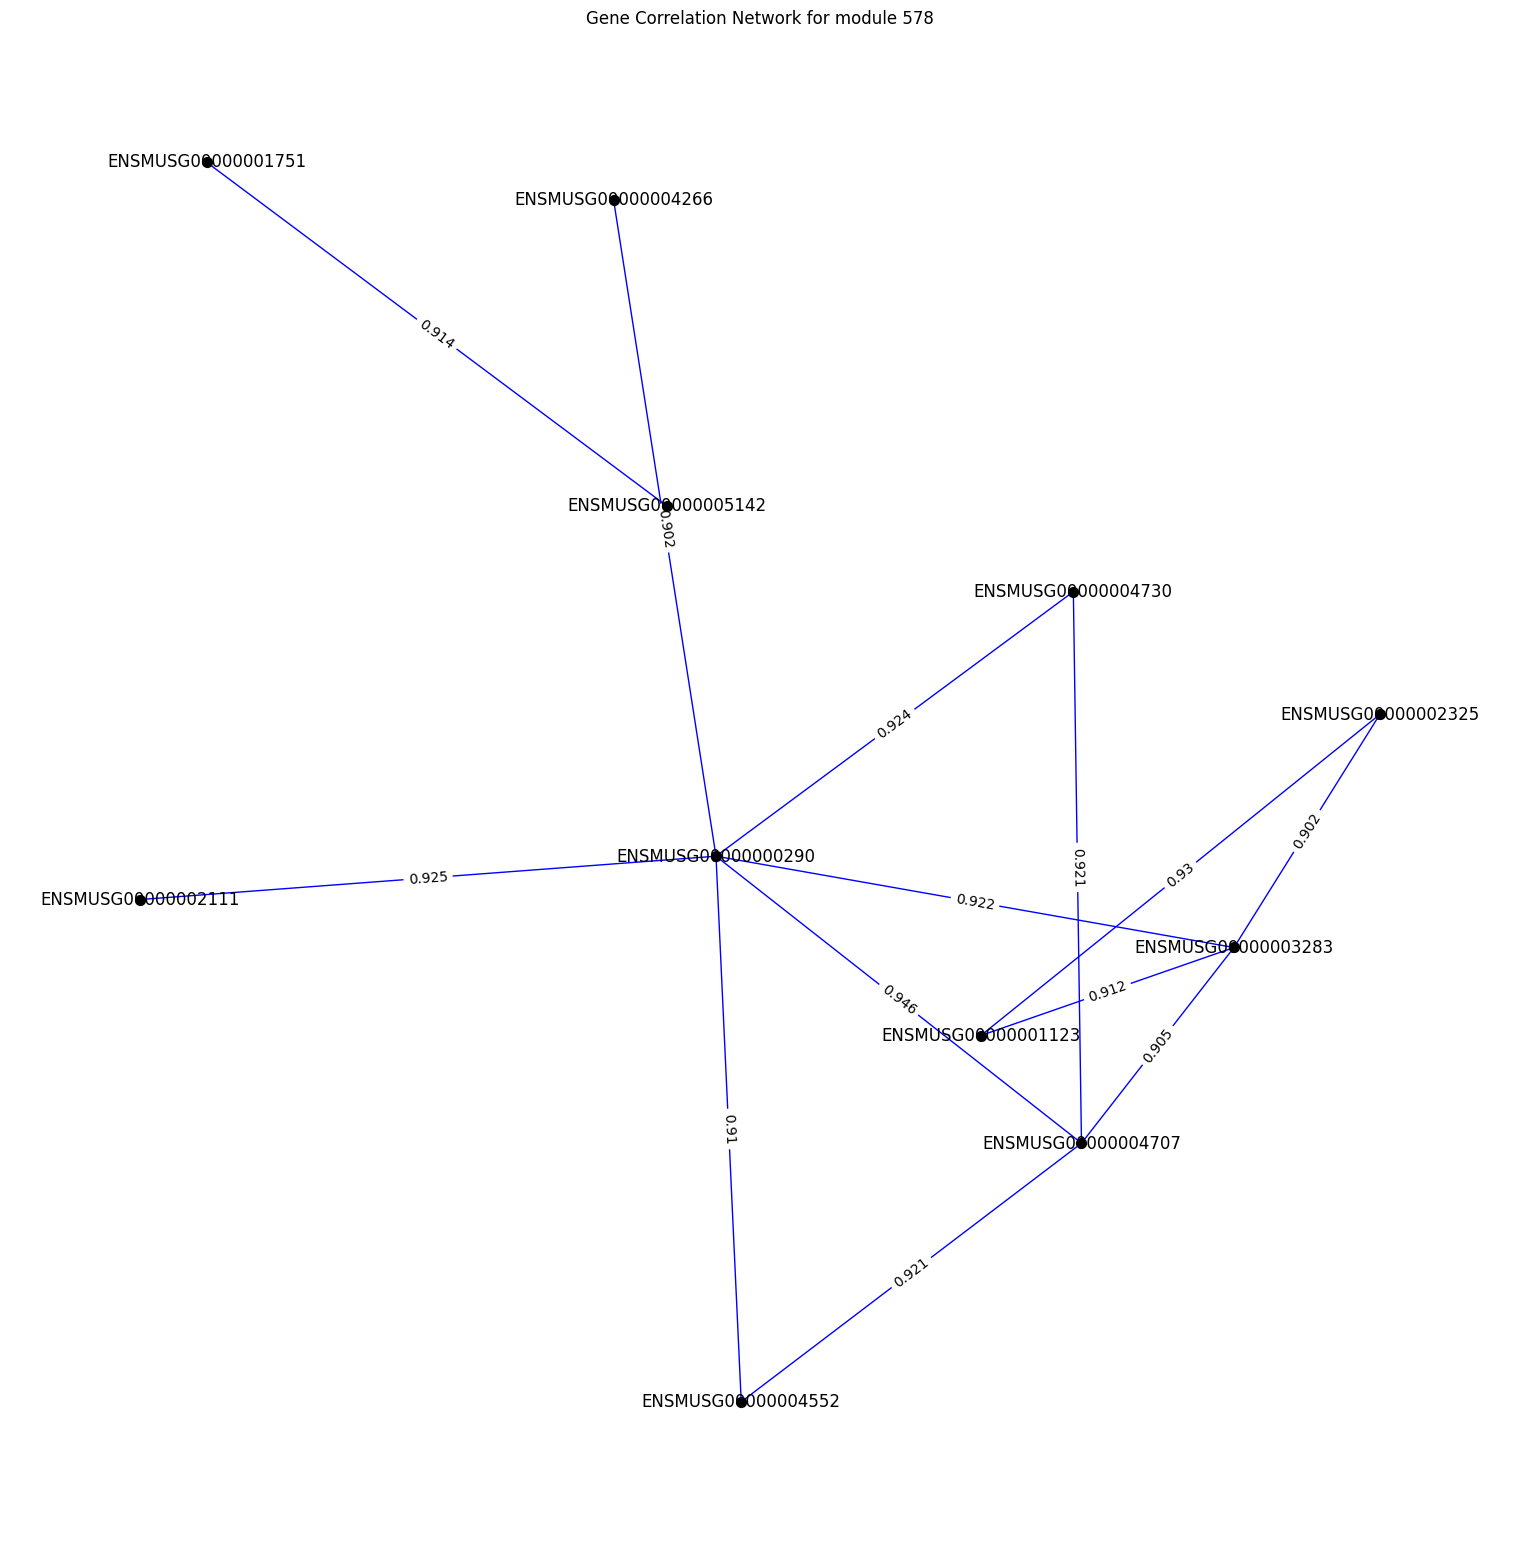

In [19]:
### MOUDLE DENDOGRAMS USING CORRELATOIN AS THE DISTANCE & CORRELATION NETWORK
minimum_num_members_to_be_cluster = 20
cn_link_threshold = 0.9
dpi_modules = 300   # quality of the figures




## Identify clusters (modules) in the dendogram
clusters = fcluster(linkage_matrix, t=module_member_threshold, criterion='distance')
num_clusters = np.unique(clusters).size
#print(f'Number of clusters identified: {num_clusters}')


## Number of members for each cluster
for i in range(1, num_clusters + 1):
    samples_in_cluster = np.where(clusters == i)[0]
    #print(f'Cluster {i} has {len(samples_in_cluster)} members.')


## Plot a denodgram for each module found in the hierarchical clustering
for cluster in range(1, num_clusters + 1):
    ## Find the genes that belong to each cluster and subset them
    samples_in_cluster = np.where(clusters == cluster)[0]
    dataset_subset = dataset_filtered.iloc[:, samples_in_cluster]


    ## Skip clusters with less members than minimum_num_members_to_be_cluster 
    if dataset_subset.shape[1] < minimum_num_members_to_be_cluster:
        #print(f"Cluster {cluster} contains less than {minimum_num_members_to_be_cluster}. Skipping...")
        continue



    ## Perform hierarchical clustering on this subset
    distances_subset = pdist(dataset_subset.T, metric='correlation')
    linkage_matrix_subset = linkage(distances_subset, method="average")
    
    plt.figure(figsize=(15, 7))  # Adjust the size as needed
    dendrogram(linkage_matrix_subset, truncate_mode=None, color_threshold=module_member_threshold, 
               labels=dataset_subset.T.index, leaf_rotation=90)
    title_module_dendogram = f'Hierarchical Clustering Dendrogram for module {cluster}.'
    plt.title(title_module_dendogram)
    plt.xlabel('Genes')
    plt.ylabel('Distance (as a measure of correlation)')
    plt.tight_layout()
    plt.savefig(working_dir + 'results\\Hierarchical_Clustering_figures\\' + title_module_dendogram, dpi=dpi_modules)
    plt.show()




    ## Weighted Netowork calculations. Using correlation as distance, filtering links with link_threshold
    # This can be made more efficint calculating the matrix only once. Now it does the calculations for the whole subset everytime.
    corr_matrix_subset = dataset_subset.corr()
    links_subset = corr_matrix_subset.stack().reset_index()
    links_subset.columns = ['gene1', 'gene2', 'weight']
    links_filtered_subset = links_subset.loc[(links_subset['weight'].abs() > cn_link_threshold) & (links_subset['gene1'] != links_subset['gene2'])]
    
    ## Make the graph plot
    network_graph = ntwkx.from_pandas_edgelist(links_filtered_subset, 'gene1', 'gene2', ['weight'])
    edge_colors = ['red' if weight > 0.95 else 'blue' for (u, v, weight) in network_graph.edges(data='weight')]

    plt.figure(figsize=(15, 15))
    node_pos = ntwkx.spring_layout(network_graph, k=0.5, iterations=20)
    ntwkx.draw(network_graph, node_pos, with_labels=True, node_size=50, node_color='black', edge_color=edge_colors)

    edge_labels = ntwkx.get_edge_attributes(network_graph, "weight")
    edge_labels = {edge: round(weight, 3) for edge, weight in edge_labels.items()}
    ntwkx.draw_networkx_edge_labels(network_graph, node_pos, edge_labels=edge_labels)

    title_module_network = f'Gene Correlation Network for module {cluster}'
    plt.title(title_module_network)
    plt.savefig(working_dir + 'results\\Hierarchical_Clustering_figures\\' + title_module_network, dpi=dpi_modules)
    plt.show()